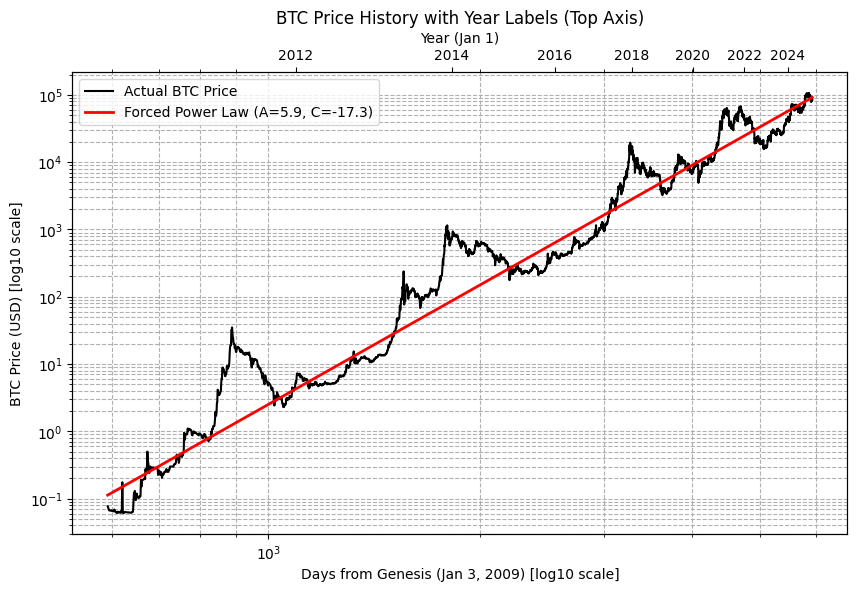

In [32]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from Data import combined_df
combined_df = combined_df[combined_df['Date'] >= pd.to_datetime('2010-08-17')].copy()

# Create the primary plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the actual BTC Price as a continuous line
ax.plot(combined_df['days_from_genesis'], combined_df['Price'],
        label="Actual BTC Price", color='black', linewidth=1.5)

# Plot the forced power-law model (if desired)
A = 5.9
C = -17.3
ax.plot(combined_df['days_from_genesis'],
        (10 ** C) * (combined_df['days_from_genesis'] ** A),
        label=f"Forced Power Law (A={A}, C={C})", color='red', linewidth=2)

# Set the primary x-axis to a base-10 logarithmic scale
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)
ax.set_xlabel("Days from Genesis (Jan 3, 2009) [log10 scale]")
ax.set_ylabel("BTC Price (USD) [log10 scale]")
ax.set_title("BTC Price History with Year Labels (Top Axis)")
ax.legend()
ax.grid(True, which="both", ls="--")

# --- Create a Secondary X-Axis for Year Labels ---
ax2 = ax.twiny()  # Create a twin axis sharing the same y-axis

# Get current x-axis limits (in days since genesis)
xlim = ax.get_xlim()
ax2.set_xscale('log', base=10)
ax2.set_xlim(xlim)

# Define the years to display: every 5th year from 2010 to 2025.
years = list(range(2010, 2026, 2))  # This yields [2010, 2015, 2020, 2025]

# Compute tick positions for January 1 of each year relative to the genesis date
tick_positions = []
tick_labels = []
for y in years:
    tick_date = datetime(y, 1, 1)
    pos = (tick_date - genesis_date).days
    # Only include ticks that fall within the current x-axis limits
    if pos >= xlim[0] and pos <= xlim[1]:
        tick_positions.append(pos)
        tick_labels.append(str(y))

ax2.set_xticks(tick_positions)
ax2.set_xticklabels(tick_labels)
ax2.set_xlabel("Year (Jan 1)")

plt.show()